# Hire-PAT fragment analyzer data analysis
It reads `fsa` files generated from ABI fragment analyzer for High-resolution Poly(A)-tail Assay (Hire-PAT)

In [1]:
# Built-in
from collections import OrderedDict
from pathlib import Path
import pickle

## Third-party
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from ipywidgets import interact
import seaborn as sns
import numpy as np

## Local
from polya.utils import FSAAnalyzer, smooth
from polya.plot import sequential_palette

In [74]:
work = "210209"

In [75]:
%%html
<style>
table {float:left}
</style>

### Sample descriptions
| Work (date) | Note | Figure |
| ---- | ----- | ---- |
| 210209 | TOP reporter LARP1 KD and 30m tracing | Figs. 4a, S4d |
| 210321 | Non-TOP reporter LARP1 KD and 30m tracing | Figs. 4b, S4d |
| 210322 | Endogenous mRNAs steady-state poly(A) length after LARP1 KD (siLARP1 #2) | Fig. S4e |

In [76]:
datadir = Path("../data/hire-pat")
smptblpath = datadir/work/"samples.txt"
smptbl = pd.read_csv(smptblpath, sep='\t', comment='#')
fsafpaths = [datadir/work/fname for fname in smptbl['Filename']]
smptbl

,Sample,Filename,Cell,Gene,Group,Baseline,Data_lane,Control_lane,Control_set
0,Mock,210209D0005_siNC_Mock.fsa,T11,5TOPwt-TRICK,siNC,153,1,4,genescan500liz
1,0 m,210209D0005_siNC_0m.fsa,T11,5TOPwt-TRICK,siNC,153,1,4,genescan500liz
2,30 m,210209D0005_siNC_30m.fsa,T11,5TOPwt-TRICK,siNC,153,1,4,genescan500liz
3,60 m,210209D0005_siNC_60m.fsa,T11,5TOPwt-TRICK,siNC,153,1,4,genescan500liz
4,90 m,210209D0005_siNC_90m.fsa,T11,5TOPwt-TRICK,siNC,153,1,4,genescan500liz
5,120 m,210209D0005_siNC_120m.fsa,T11,5TOPwt-TRICK,siNC,153,1,4,genescan500liz
6,Mock,210209D0005_siLARP1-3_Mock.fsa,T11,5TOPwt-TRICK,siLARP1-3,153,1,4,genescan500liz
7,0 m,210209D0005_siLARP1-3_0m.fsa,T11,5TOPwt-TRICK,siLARP1-3,153,1,4,genescan500liz
8,30 m,210209D0005_siLARP1-3_30m.fsa,T11,5TOPwt-TRICK,siLARP1-3,153,1,4,genescan500liz
9,60 m,210209D0005_siLARP1-3_60m.fsa,T11,5TOPwt-TRICK,siLARP1-3,153,1,4,genescan500liz


#### Visualise raw fluorescence signals

GeneScanLIZ500 size markers (bp)  
35, 50, 75, 100, 139, 150, 160, 200, 250, 300, 340, 350, 400, 450, 490, 500

typically, data_lane = 1 and marker_lane = 4 or 105

In [77]:
# Load data for every fsa file
lanes = [1, 4]
fsas = OrderedDict()
for idx, fsafpath in zip(smptbl.index, fsafpaths):
    fsa = FSAAnalyzer(fsafpath, marker_lane=4)
    for lane in lanes:
        fsa.load(lane)
        fsa.get_marker_peaks(height_filter_tolerance_factor=0.5)
        
    fsas[idx] = fsa


In [78]:
# Visualize raw signal intensity by lane for sanity check
# Also, find and show peak positions for the marker lane

lanes = [1,4]
xlim= 800,8000
ylim= 0,2000

def show_intensity_by_lane(lane, c, force):
    global fsafpaths, xlim, ylim
    fig, axes = plt.subplots(len(fsafpaths), 1, figsize=(8,len(fsafpaths)*1), sharex=True)
    plt.subplots_adjust(hspace=0)
    for i, fsa in fsas.items():
        ax = axes.ravel()[i]
        smp = smptbl.iloc[i,0]
        
        y = fsa.data[lane]
        x = np.arange(len(y))
        
        ax.plot(x, y, c=c)
        
        if lane == fsa.marker_lane:
            for x in fsa.get_marker_peaks(force=force, height_filter_tolerance_factor=0.5):
                ax.axvline(x, color="r", ls='--', alpha=0.5)
        
        ax.text(0.99, 0.05, s=f"fidx:{i}, {smp}", transform=ax.transAxes, ha='right')
        
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim) 
        
    plt.show()
    return
# show_intensity_by_lane(lane, xlim=(500,1500), c='gray')
interact(show_intensity_by_lane, lane=lanes[::-1], c='gray', force=True)

interactive(children=(Dropdown(description='lane', options=(4, 1), value=4), Text(value='gray', description='c…

<function __main__.show_intensity_by_lane(lane, c, force)>

### Manually correct the marker peak positions (optional)

In [57]:
def show_signals_with_marker_peaks(fsa, marker_peaks, lane=4, xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(5,1))
    y = fsa.data[lane]
    x = np.arange(len(y))
    ax.plot(x, y)
    
    for x in marker_peaks:
        ax.axvline(x, color="r", ls='--', alpha=0.5)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    
    print(marker_peaks)
    return

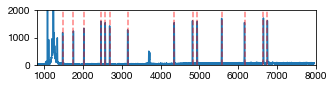

[1470 1747 2017 2458 2570 2683 3148 4350 4821 4943 5574 6163 6651 6753]


In [58]:
fidx = 17
fsa = fsas[fidx]
# marker_peaks = fsa.get_marker_peaks(force=True, height_filter_tolerance_factor=0.5)
show_signals_with_marker_peaks(fsa, fsa.marker_peaks, xlim=xlim, ylim=ylim)

In [59]:
fixes = {
    "210321": {
        17: [[3700],[]],
    }
}

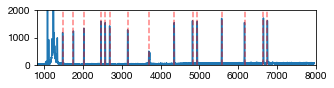

[1470 1747 2017 2458 2570 2683 3148 3700 4350 4821 4943 5574 6163 6651
 6753]


In [60]:
fix = True

fidx = 17
fsa = fsas[fidx]

to_add = fixes[work][fidx][0]
to_remove = fixes[work][fidx][1]


fsa.add_marker_peaks(to_add)
fsa.remove_marker_peaks(to_remove)
    
show_signals_with_marker_peaks(fsa, fsa.marker_peaks, xlim=xlim, ylim=ylim)
    
if fix is False:
    fsa.remove_marker_peaks(to_add)
    fsa.add_marker_peaks(to_remove)



### Plotting the results

5TOPwt-TRICK siLARP1-3


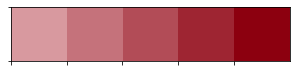

5TOPwt-TRICK siLARP1-SM


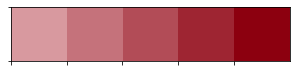

5TOPwt-TRICK siNC


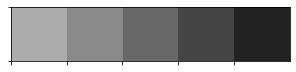

In [80]:
## Color settings

color_graduation = True
color_grad_pads = (2,0)
include_mock = False

if include_mock is False:
    smptbl = smptbl[smptbl['Sample'] != 'Mock']

# colors by group
colors = { 
    'mock': '#000000',
    'Mock': '#000000',
    'siNC': '#222222',
    
    'LARP1': '#8C000F',
    'siLARP1': '#8C000F',
    'siLARP1-3': '#8C000F',
    'siLARP1-SM': '#8C000F',
    
    'LARP4': '#93C01F',
    'siLARP4_4B': '#0A481E',
    
    'siDecay': '#6A008B',    
}

palettes = dict()
for (gene, group), gr in smptbl.groupby(['Gene','Group']):
    if color_graduation is True:
        n_colors = len(gr)
        palette = sequential_palette(colors.get(group, 'black'), n_colors + np.sum(color_grad_pads))[color_grad_pads[0]: color_grad_pads[0] + n_colors]
        
    else:
        palette = [colors[smp] for smp in gr.loc[:,'Sample']]
        
    if include_mock is True:
        palette = [[0,0,0]] + palette[1:]
        
    palettes[(gene,group)] = palette
    
    sns.palplot(palette)
    print( gene, group )
    plt.show()

Plot individually

../plots/hire-pat_210209-T11-5TOPwt-TRICK-siLARP1-3_normed_mini.pdf


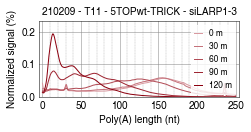

../plots/hire-pat_210209-T11-5TOPwt-TRICK-siLARP1-SM_normed_mini.pdf


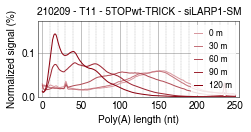

../plots/hire-pat_210209-T11-5TOPwt-TRICK-siNC_normed_mini.pdf


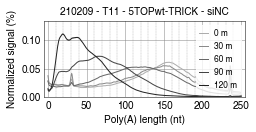

In [82]:
# Configurations
savefig = True
savepkl = False
normed = True
rescale_intensity = None
display_pAmode = False
# figsize = 9, 3.4
figsize = 7.2, 2.8
xmin, xmax = 0, 250 # a range of poly(A) tail length
smoothing_window_len = 60

minifig = True

styles = ['barricade']
if minifig is True: 
    styles.append('mini')
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    groups = smptbl.groupby(['Gene', 'Cell', 'Group'])
    for (gene, cell, group), gr in groups:
        fig, ax = plt.subplots(figsize=figsize)
        pAmodes = list()
        global_ymax = None
        
        for ci, (idx, entry) in enumerate(gr.iterrows()):
            fsa = fsas[idx]
            size, intensity = fsa.get(entry['Data_lane'])
            size -= entry['Baseline'] # exclude the mRNA body size
            target_range = (xmin < size) * (size < xmax)
            
            x = size[target_range]
            
            y = smooth(intensity[target_range], window_len=smoothing_window_len)
            y += np.abs(y.min()) # correct the intensity baseline
            
            if rescale_intensity is not None: y = np.interp( y, (y.min(), y.max()), rescale_intensity ) 
            if normed is True: y = y / y.sum() * 100
                
            if global_ymax is None: global_ymax = y.max()
            elif global_ymax < y.max(): global_ymax = y.max()
                
            # additional touch for DMSO vs. Torin 1 comparison
            smp = entry['Sample']
            ls = 'dotted' if smp.lower() == 'mock' else '-'
                
            ax.plot(x, y, color=palettes[(gene,group)][ci], label=smp, ls=ls, alpha=1)
            
            if display_pAmode is True:
                pAmode = x[np.argmax(y)]
                ax.text(x=pAmode, y=y.max(), s="*", ha="center", color=palettes[(gene,group)][ci], 
                        fontsize="xx-large", fontweight="bold", alpha=1)
            
            if savepkl is True:
                outpklpath = datadir/work/entry["Filename"].replace('.fsa','.pkl')
                pickle.dump(tuple([x,y]), open(outpklpath, 'wb'))
            
        ## Grid and axes
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(1)) 
        ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
        ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
        ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
        ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
        ax.set_xlim(xmin-5,xmax+5)
        ax.set_ylim([0,global_ymax*1.2])
#         ax.set_ylim([0, 0.3])
        
        ## Texts and labels
        ax.set_title("{} - {} - {} - {}".format(work, cell, gene, group), fontsize='medium')
        xlabel = "Poly(A) length (nt)"
        ylabel = "Normalized signal (%)" if normed is True else "Signal intensity (a.u.)"
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
        ax.legend(loc="upper right", handlelength=1.0, ncol=1, columnspacing=0.8, fontsize='small')
        
        fname_adduct = ""
        if savefig is True:
            if normed: fname_adduct += "_normed"
            if minifig is True: fname_adduct += "_mini"
            outfigpath = "../plots/hire-pat_{}-{}-{}-{}{}.pdf".format(work, cell, gene, group, fname_adduct)
            plt.savefig(outfigpath, dpi=300, bbox_inches="tight")
            print(outfigpath)
        plt.show()
